In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

In [6]:
using PyCall;
# only needed once
# using Conda;
# Conda.add("qutip");
# Conda.add("imageio");

# Single Qubit System

In [7]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [spindown(bq_single)]
;

In [8]:
# Base Dynamics
tf = 1.0 #ns
tspan = [0.0:0.01:tf;]
psi0 = normalize(spinup(bq_single)*.25 + spindown(bq_single)*.75)

# Dynamic function
function Ht(t,psi)
    return H₀_single
end

tout, psi_t = timeevolution.schroedinger_dynamic(tspan, psi0, Ht);

In [9]:
# animate_bloch(psi_t, duration=0.03, save_all=true)

# Set up Dynamics

In [10]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [spindown(bq_single)]
;

In [11]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [12]:
model = QC.QuantumState();

In [13]:
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 3.0 # ns, total time
dt = tf / (N-1) # time step

obj = gen_default_objective(state_dim, control_dim, ψt_state; N=N, tf=tf, R_scale=0.0001)

Objective

In [14]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)


# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

In [15]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model), constraints=cons);

In [16]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [17]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [18]:
solve!(solver);

┌ Warning: A not upper triangular. Creating a new upper-triangular matrix.
└ @ Altro.Cqdldl /Users/phionx/.julia/packages/Altro/jipqO/src/qdldl.jl:156


In [19]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [18]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 0
Final cost: 1.549727762840902
Final constraint satisfaction: 1.012342550580687


# Save Data

In [19]:
# save data (uncomment to save)
# save_solver_data(solver, label="data/pi_pulse_0_to_1_data")

In [20]:
# load data
data = load_solver_data("data/pi_pulse_0_to_1_data.jld2")

Dict{String, Vector} with 2 entries:
  "U" => SVector{2, Float64}[[0.0633956, -1.2342], [0.179264, -1.22276], [0.293…
  "X" => SVector{4, Float64}[[1.0, -1.1418e-18, -2.87885e-19, 0.0], [0.998892, …

# Analysis

In [21]:
X = data["X"]    # alternatively states(prob)
U = data["U"]   # alternatively controls(prob)
Ucv = controls_to_amplitudes(U)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Uav = map(cv -> norm(cv)[1], Ucv)
Xqv = states_to_kets(X, bq_single)
;

In [22]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
  1.0 - 0.0im
 -0.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 -3.6998e-13 + 9.33e-15im
         1.0 + 2.58e-15im


In [23]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

# Plots

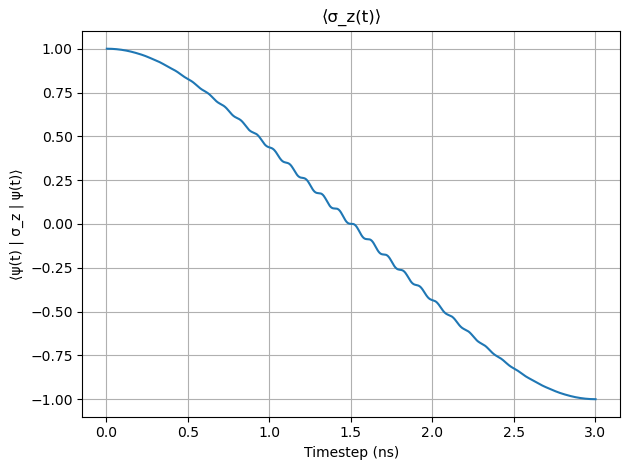

In [24]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

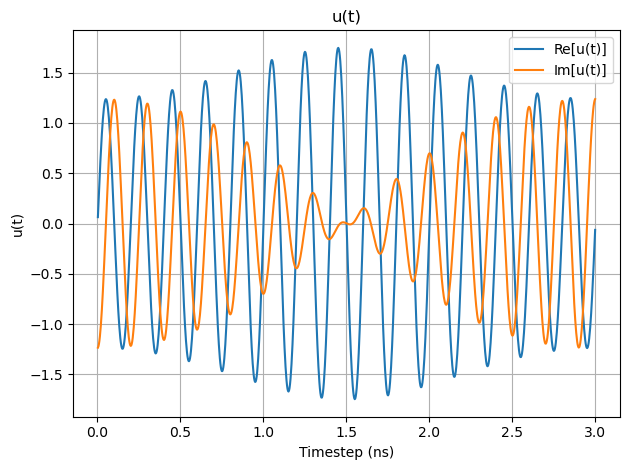

In [43]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

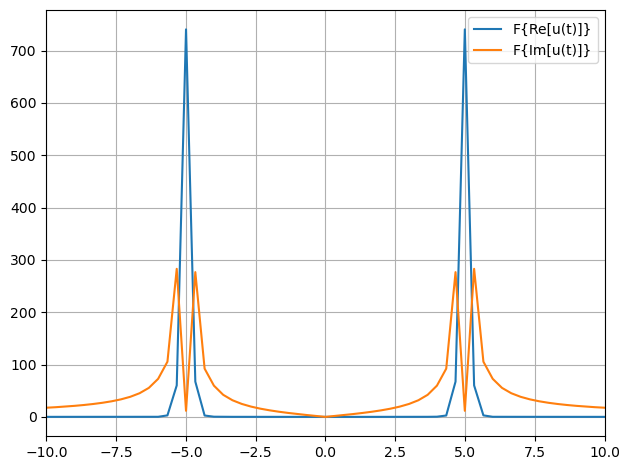

In [52]:
using FFTW
# using DSP

# Sample period
Ts = dt*N/(N-1)
# Start time 
t0 = 0 
tmax = tf
# time coordinate
t = t0:Ts:tmax


# real
signal = Urv
F_r = fft(signal) |> fftshift
freqs_r = fftfreq(length(t), 1.0/Ts) |> fftshift

# real
signal = Uiv
F_i = fft(signal) |> fftshift
freqs_i = fftfreq(length(t), 1.0/Ts) |> fftshift

# plots 
# time_domain = plot(t, signal)

freq_domain = plot(freqs, abs.(F_r), label="F{Re[u(t)]}")
freq_domain = plot(freqs, abs.(F_i), label="F{Im[u(t)]}")
xlim(-10,10)
grid("on")
legend()
tight_layout()

In [25]:
Xqv

1001-element Vector{Ket{SpinBasis{1//2, Int64}, Vector{ComplexF64}}}:
 Ket(dim=2)
  basis: Spin(1/2)
  1.0 - 0.0im
 -0.0 + 0.0im
 Ket(dim=2)
  basis: Spin(1/2)
   0.9988881708785262 - 0.0471061385752977im
 -0.00185060839987321 - 9.505802142023e-5im
 Ket(dim=2)
  basis: Spin(1/2)
   0.9955552935623093 - 0.09410591127247683im
 -0.00368812151609445 - 0.00036425722197445im
 Ket(dim=2)
  basis: Spin(1/2)
   0.9900091739986806 - 0.1408933377395587im
 -0.00550022941854892 - 0.00080638415179801im
 Ket(dim=2)
  basis: Spin(1/2)
   0.9822627540611253 - 0.18736313812616212im
 -0.00727472355853803 - 0.00141945514788628im
 Ket(dim=2)
  basis: Spin(1/2)
   0.9723340183257746 - 0.23341105762493644im
 -0.00899954445293471 - 0.00220072363113058im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9602458718604605 - 0.2789341643034062im
 -0.0106628280201009 - 0.00314668999400135im
 Ket(dim=2)
  basis: Spin(1/2)
   0.9460259962584256 - 0.32383111437216217im
 -0.01225295027031902 - 0.0042531138487003im
 Ket(dim=2)
  basi

In [28]:
# animate_bloch(Xqv[1:2:end], duration=0.03, save_all=true)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)